# imports

In [16]:
import numpy as np
from abc import ABC, abstractclassmethod
import math
from typing import Callable, Dict, List
import matplotlib.pyplot as plt
import threading

# context class

In [7]:
class Strategy(ABC):
    @abstractclassmethod
    def process(self,probablity:float, item_count:int, times:int, ret_fun:Callable) -> np.ndarray:
        pass
    

class Context():
    _strategy:Strategy
    _plot_data:List[float]
    _plot_label:List[int]
    def __init__(self, strategy:Strategy) -> None:
        self._strategy = strategy

    def calculate(self, probablity:float, item_count:int, times:int, ret_fun:Callable) -> int:
        return self._strategy.process(probablity, item_count, times,ret_fun)
    
    def MC(self, probablity:float, item_count:int, times:int, ret_fun:Callable) -> int:
        return np.average(np.sum(self.calculate(probablity,item_count,times,ret_fun),axis=1))
    
    def plot_data(self, probablity:float, times:int, ret_fun:Callable, start_data:int=3, stop_data:int=150) -> None:
        rtn = {x:self.MC(probablity, x, times, ret_fun) for x in range(start_data,stop_data  + 1)}
        self._plot_data = list(rtn.values())
        self._plot_label = list(rtn.keys())
        #return rtn

# strategy classes

## binomial process

In [8]:
twentyfive_percent = lambda item_count: (np.random.default_rng().binomial(2,1/3,math.floor(item_count/3))+1)
ten_percent = lambda item_count: 3
uniform_25_function = lambda item_count: (np.random.default_rng().integers(1,3,math.floor(item_count/3)))
class binomial_dist(Strategy):
    def process(self,probablity:float,item_count:int, times:int, ret_fun:Callable) -> np.ndarray:
        return np.array([np.random.default_rng().binomial(1,probablity,math.floor(item_count/3))*ret_fun(item_count) for _ in range(0,times)])
class binomial_proc(Strategy):
    def process(self,probablity:float,item_count:int, times:int, ret_fun:Callable) -> np.ndarray:
        rtn = []
        for i in range(0,times):
            temp_row = []
            for j in range(0, math.floor(item_count/3)):
                temp_row.append(ret_fun(item_count)*np.random.default_rng().binomial(1,probablity,1)[0])
            rtn.append(temp_row)
        return np.array(rtn)
class uniform_dist(Strategy):
    def process(self,probablity:float,item_count:int, times:int, ret_fun:Callable) -> np.ndarray:
        max_num = math.floor(1/probablity)+1
        random = np.random.default_rng().integers(0,max_num,math.floor(item_count/3))
        random[random != 1] = 0
        return np.array([random*ret_fun(item_count) for _ in range(0,times)])    

In [128]:
times = 2**13
binom_10_dist = Context(binomial_dist())
#binom_10_proc = Context(binomial_proc())
binom_25_dist = Context(binomial_dist())
uniform_25_dist = Context(uniform_dist())
uniform_10_dist = Context(uniform_dist())
#binom_25_proc = Context(binomial_proc())


In [129]:
threads = [
    threading.Thread(target=binom_10_dist.plot_data(0.1,times, ten_percent)),
    #threading.Thread(target=binom_10_proc.plot_data(0.1,100, ten_percent)),
    threading.Thread(target=binom_25_dist.plot_data(0.25,times, twentyfive_percent)),
    #threading.Thread(target=binom_25_proc.plot_data(0.25,100, twentyfive_percent)),
    threading.Thread(target=uniform_25_dist.plot_data(0.25,times, uniform_25_function)),
    threading.Thread(target=uniform_10_dist.plot_data(0.1,times, ten_percent))
]
for t in threads:
    t.start()
for t in threads:
    t.join()

# Plot(s)

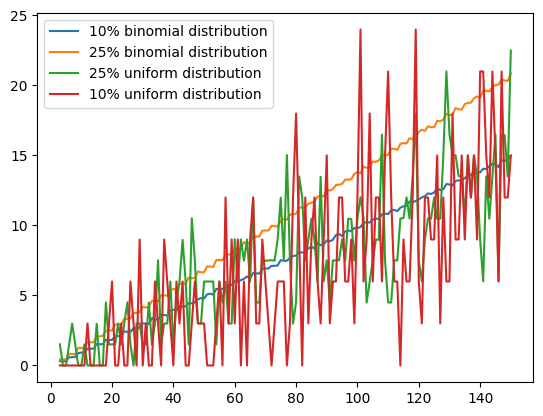

In [130]:
fig, ax = plt.subplots()
ax.plot(binom_10_dist._plot_label, binom_10_dist._plot_data, label="10% binomial distribution")
#ax.plot(binom_10_proc._plot_label, binom_10_proc._plot_data, label="10% binomial walk")
ax.plot(binom_25_dist._plot_label, binom_25_dist._plot_data, label="25% binomial distribution")
#ax.plot(binom_25_proc._plot_label, binom_25_proc._plot_data, label="25% binomial walk")
ax.plot(uniform_25_dist._plot_label, uniform_25_dist._plot_data, label="25% uniform distribution")
ax.plot(uniform_10_dist._plot_label, uniform_10_dist._plot_data, label="10% uniform distribution")

ax.legend()
plt.show()